# Test Function Selection \& Test Matrices
## Minimum radius selection
## Building test function matrix and derivatives

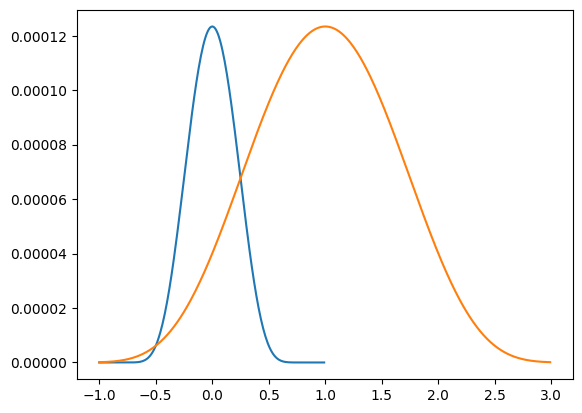

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, ifft

# Test function: This is centered at 0
def phi(t, r=2, c=0):
    return np.exp(
        -9 / np.maximum((1 - ((t - c) / r) ** 2), 1e-10)

    )  # We use 1e-10 instead of 0, otherwise we divide by 0


t = np.arange(-1, 1, 0.01)

plt.clf()
plt.plot(t, phi(t, r=1))
# What about a different centeringp?
t = np.arange(-1, 3, 0.01)
plt.plot(t, phi(t, r=3, c=1))

In [283]:
# In practice this is what we will use and map the domain (-1,1) to (0,T)
def phi(t, eta=9):
    return np.exp(-eta * (1 - t ** 2) ** -1 )

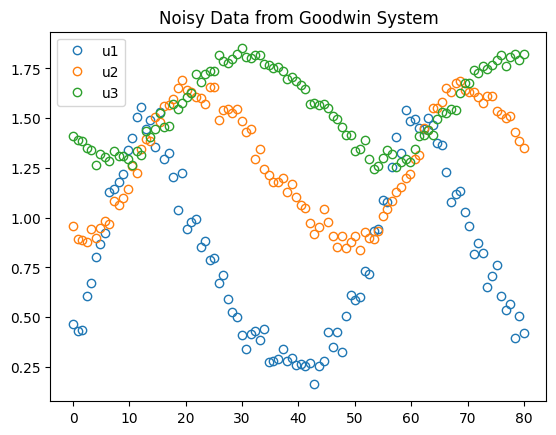

In [292]:
def goodwin_3d(t, u, p):
    du1 = p[0] / (2.15 + p[2] * u[2]**p[3]) - p[1] * u[0]
    du2 = p[4] * u[0] - p[5] * u[1]
    du3 = p[6] * u[1] - p[7] * u[2]
    return [du1, du2, du3]

# Example from Nic's Julia code
def getSystemInfo(npoints=100, t_span=[0, 80], noise_ratio=0.1):
    t_eval = np.linspace(t_span[0], t_span[1], npoints)
    u0 = [0.3617, 0.9137, 1.3934]
    p_star = [3.4884, 0.0969, 1, 10, 0.0969, 0.0581, 0.0969, 0.0775]

    sol = solve_ivp(
        goodwin_3d,
        t_span,
        u0,
        args=(p_star,),
        dense_output=True,
        rtol=1e-8,
        atol=1e-10,
        t_eval=t_eval,
    )

    tt = sol.t
    u_star = sol.y.T

    noise = np.random.randn(npoints, 3) * (noise_ratio * np.std(u_star, axis=0))
    u_noisy = u_star + noise

    return u_noisy, tt

[U, t] = getSystemInfo(noise_ratio=0.15)
u1, u2, u3 = U[:, 0], U[:, 1], U[:,2]

plt.clf()
plt.title("Noisy Data from Goodwin System")
plt.plot(t, u1, marker="o", linestyle="None", markerfacecolor="none", label="u1")
plt.plot(t, u2, marker="o", linestyle="None", markerfacecolor="none", label="u2")
plt.plot(t, u3, marker="o", linestyle="None", markerfacecolor="none", label="u3")

plt.legend()

In [293]:
def sanitize_radius_params(U, tt, radius_min_time=0.01, radius_max_time=5, radius_params=np.linspace(1, 12, 12)):
    len_tt = len(tt)  # length of time array
    dt = np.mean(np.diff(tt))
    radius_interior_domain = int(np.floor((len_tt - 2) / 2))  # radius as number of data points
    radius_max = int(np.ceil(radius_max_time / dt)) # max input radius as the number of data points
    radius_min = int(max(np.ceil(radius_min_time / dt), 1))  # Min radius of 1 for now

    if radius_max > radius_interior_domain:
        radius_max = radius_interior_domain

    return([radius_min, radius_max, radius_params])


def build_test_function_support_indices(radius, n_test_functions, len_tt):
    n_diameter = 2 * radius + 1
    n_interior = len_tt - 2  # Exclude boundaries

    if n_diameter > n_interior:
        raise ValueError("n_diameter must be <= n_interior")

    if n_test_functions is None:
        gap = 1
        n_test_functions = (n_interior - n_diameter) // gap + 1
    else:
        if n_test_functions < 1:
            raise ValueError("n_test_functions must be >= 1")
        if n_test_functions == 1:
            gap = int(np.floor((n_interior - n_diameter) /2))
            print(f"gap: {gap}")
        else:
            max_start = n_interior - n_diameter
            gap = max_start // (n_test_functions - 1)

    indices = []
    for j in range(n_test_functions):
        start = j * gap + 1  # Offset by 1 to skip the boundary
        end = start + n_diameter

        if n_test_functions == 1:
            start = gap
            end = start + n_diameter

        if end > len_tt - 1:
            start = len_tt - 1 - n_diameter
            end = len_tt - 1
        indices.append(list(range(start, end)))

    return indices

def build_test_function_matrix(n_radius, tt, n_test_functions=None):
    len_tt = len(tt)
    n_diameter = 2 * n_radius + 1

    # diameter can't be larger than the domain
    if n_diameter > len_tt - 2:
        n_radius = int(np.floor((len_tt - 2) / 2))

    indices = build_test_function_support_indices(
        n_radius, n_test_functions, len_tt
    )

    V = np.zeros((len(indices), len_tt))

    xx = np.linspace(-1, 1, n_diameter + 2)[1:-1] # Don't include the endpoints (support is zero & this is used in build_test_function_support_indicies)
    v_rowk = phi(xx) / np.linalg.norm(phi(xx), ord=2)  # For stability

    for i, support_indices in enumerate(indices):
        V[i, support_indices] = v_rowk[: len(support_indices)]
    return V

n_points = 160


U, tt = getSystemInfo(t_span=[0,80], noise_ratio=0.15, npoints=n_points)

radius_params = np.linspace(1, 12, 12)

radius_min, radius_max, radius_params = sanitize_radius_params(U, tt, radius_params=radius_params)

radii = radius_params*radius_min
radii = np.array([r for r in radii if r < radius_max], dtype=int)

V_full = np.vstack([build_test_function_matrix(int(i), tt) for i in radii])
V_full

array([[0.00000000e+00, 4.96641155e-02, 9.97530426e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.96641155e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.08325025e-17, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.61320148e-08, 1.08325025e-17, 0.00000000e+00]],
      shape=(1332, 160))

errors: [5.07906775 0.53506845 0.61026554 0.52271754 0.50886254 0.50101612
 0.4982075  0.50096722]


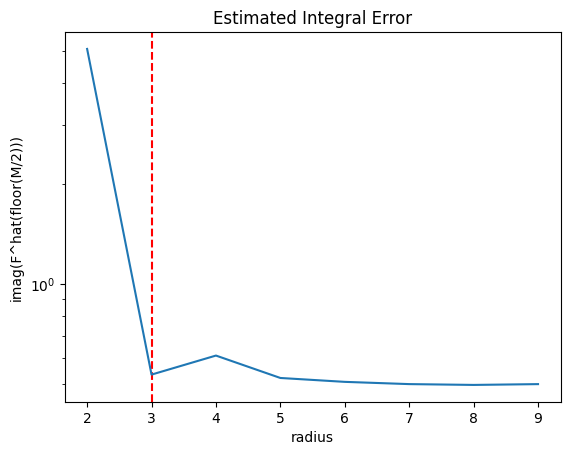

In [416]:
n_points = 160
U, tt = getSystemInfo(t_span=[0,80], noise_ratio=0.15, npoints=n_points)

# https://en.wikipedia.org/wiki/Knee_of_a_curve Look at Detection methods
# Looks like you can do two linear regressions or in this case we look at the secant lines.
def get_corner(yy, xx=None):
    yy = np.asarray(yy, dtype=float)
    N = len(yy)
    if xx is None:
        xx = np.arange(1, N+1)
    else:
        xx = np.asarray(xx, dtype=float)
    # Scale by maximum value for stability
    yy_scaled = (yy / np.max(np.abs(yy))) * N
    errs = np.zeros(N)
    for k in range(N):
        # Avoid division by zero
        if xx[k] == xx[0] or xx[-1] == xx[k]:
            errs[k] = np.inf
            continue
        # Secant line for the first segment
        l1 = (yy_scaled[k] - yy_scaled[0]) / (xx[k] - xx[0]) * (xx[:k+1] - xx[k]) + yy_scaled[k]
        # Secant line for the second segment
        l2 = (yy_scaled[-1] - yy_scaled[k]) / (xx[-1] - xx[k]) * (xx[k:] - xx[k]) + yy_scaled[k]
        # Relative L1 error
        err1 = np.sum(np.abs((l1 - yy_scaled[:k+1]) / yy_scaled[:k+1]))
        err2 = np.sum(np.abs((l2 - yy_scaled[k:]) / yy_scaled[k:]))
        errs[k] = err1 + err2
    # Replace NaNs with inf
    errs = np.where(np.isnan(errs), np.inf, errs)
    ix = np.argmin(errs)
    return ix

def find_min_radius_int_error(U, tt, radius_min, radius_max,n_test_functions,num_radii =100, sub_sample_rate = 2):
    """
      To analyze the Discrete Fourier Transform of the data we want a matrix where
       each column represents a time slice at t_i, and each row element takes the form phi_k(t_i)*u_D(t_i),
       a different test function at t_i multiplied the state in a particular dimension at t_i
     - We accomplish this with numpy broadcasting and the following tensor product:
     - V[:, :,None] * U[None, :,:])
     - (K, Mp1, 1)  *  (1, Mp1, D) = (K, Mp1, D) <-- Dimension broadcast analysis
     - The multiplication broadcasted by numpy, moving through dimensions left to right is:
           (dim 1) We have K test functions, so the data ("1 set of data") get stretched to multiply through K times
           (dim 2) Multiply element wise data (mp1 points) and test func evals (mp1 points) for each time step
           (dim 3) The test function eval dim 1  stretches to hit all the dimensions of the data dim D  in the system
      - Reshape the product so for column i (time point), the row elements take the form phi_k(t_i)_D u(t_i)
          - First we look at transpose:
            2D extends to tensors: For dim=2 we swap rows with columns, can do the same, swapping higher dimensions
            Eg 2x3x4.T with swapping dimension (1,2,0) has dimension 3x4x2. We need this before reshaping
            (K, Mp1, D) --> Transpose with swapping dim (0,2,1) --> (K,D,Mp1)
         - When reshape we unravel at the highest dimension and step down. In total, we have  K*D*Mp1 elements
           (K,D,Mp1) --> reshape (K*D, Mp1) march along Mp1 elements, (1 dimension and test func), then new row and start over
    """
    Mp1,D = U.shape
    step = int(np.ceil((radius_max - radius_min)/num_radii))
    radii  = np.arange(radius_min, radius_max, step)
    errors = np.zeros(len(radii))

    IX = int(np.floor((Mp1-1) / sub_sample_rate))

    for (i, r) in enumerate(radii):
        V_r = build_test_function_matrix(r, tt, n_test_functions=n_test_functions)
        K = V_r.shape[0]
        G = V_r[:, :, np.newaxis] * U[np.newaxis, :, :]  # (K, Mp1, D) Essentially element wise for each dimension phi(t_i) and u(t_i) for all phi_k
        G = np.transpose(G, (0, 2, 1))   # (K, D, Mp1) Need this so reshaping works the way we want
        G = G.reshape(K*D, Mp1)  # For column i (index time), one row is phi_k(t_i)u(t_i)[D] <- Dth dimension
        f_hat_G = fft(G, axis=1) # Time steps in the second dimension
        errors[i]=  np.linalg.norm(np.imag(f_hat_G[:, IX]))
    min_idx = get_corner(errors)
    return min_idx, errors, radii

min_idx, errors, radii = find_min_radius_int_error(U, tt, radius_min = 2, radius_max = 10, n_test_functions =100, num_radii =200, sub_sample_rate = 2)
corner_radius = radii[min_idx]
plt.axvline(corner_radius, color='red', linestyle='--', label=f'Corner: radius={corner_radius}')
plt.title("Estimated Integral Error")
plt.ylabel("imag(F^hat(floor(M/2)))")
plt.xlabel("radius")
plt.semilogy(radii, errors)
print(f"errors: {errors}")

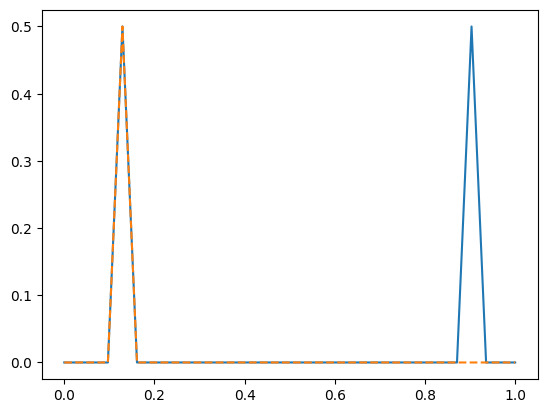

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

def f(t):
    return np.sin(2 * np.pi * 4 * t)

def fourier_series_coeffs(func, T, N):
    """Compute N Fourier series coefficients for func on [0, T]"""
    coeffs = []
    for k in range(N):
        integrand = lambda t: func(t) * np.exp(-1j * 2 * np.pi * k * t / T)
        c_k, _ = quad(lambda t: np.real(integrand(t)), 0, T)
        c_k_im, _ = quad(lambda t: np.imag(integrand(t)), 0, T)
        c_k = (c_k + 1j * c_k_im) / T
        coeffs.append(c_k)
    return np.array(coeffs)


N = 32
T = 1.0
t_samples = np.linspace(0, T, N, endpoint=False)
x_samples = f(t_samples)

dft_coeffs = np.fft.fft(x_samples) / N
dft_coeffs[np.isclose(np.abs(dft_coeffs), 0, atol=1e-10)] = 0

fs_coeffs = fourier_series_coeffs(f, T, N)
fs_coeffs[np.isclose(np.abs(fs_coeffs), 0, atol=1e-10)] = 0

t = np.linspace(0,T, 32)

plt.plot(t, np.abs(dft_coeffs))
plt.plot(t, np.abs(fs_coeffs), linestyle='--')

In [13]:
m = 4

print(f"DFT coefficient for mode {m}: {dft_coeffs[m]}")
print(f"Fourier series coefficient for mode {m}: {fs_coeffs[m]}")
print(f"Absolute error: {abs(dft_coeffs[m] - fs_coeffs[m])}")

# We see that the 31 modes are not estimated well at all by the DFT!
print(dft_coeffs[N - 2])
print(fs_coeffs[N - 2])

DFT coefficient for mode 4: (-2.4593447300353797e-16-0.5000000000000002j)
Fourier series coefficient for mode 4: (7.974173103305335e-17-0.5j)
Absolute error: 3.941684873908576e-16
0j
0j


In [14]:
s = 4  # Subsampling factor
N_sub = N // s
t_sub = t_samples[::s]
x_sub = x_samples[::s]
dft_sub = np.fft.fft(x_sub) / N_sub

# The m-th mode in the original data aliases to m' in the subsampled DFT
m = 28  # Try a high mode
m_alias = m % N_sub

print(f"Original DFT coefficient for mode {m}: {dft_coeffs[m]}")
print(f"Subsampled DFT coefficient for aliased mode {m_alias}: {dft_sub[m_alias]}")
print(f"Fourier series coefficient for mode {m}: {fs_coeffs[m]}")

Original DFT coefficient for mode 28: (-2.1817889738790906e-16+0.5000000000000002j)
Subsampled DFT coefficient for aliased mode 4: (-4.286263797015736e-16+0j)
Fourier series coefficient for mode 28: 0j


Now let us look at a function that has a frequency higher than the Nyquist Freqency

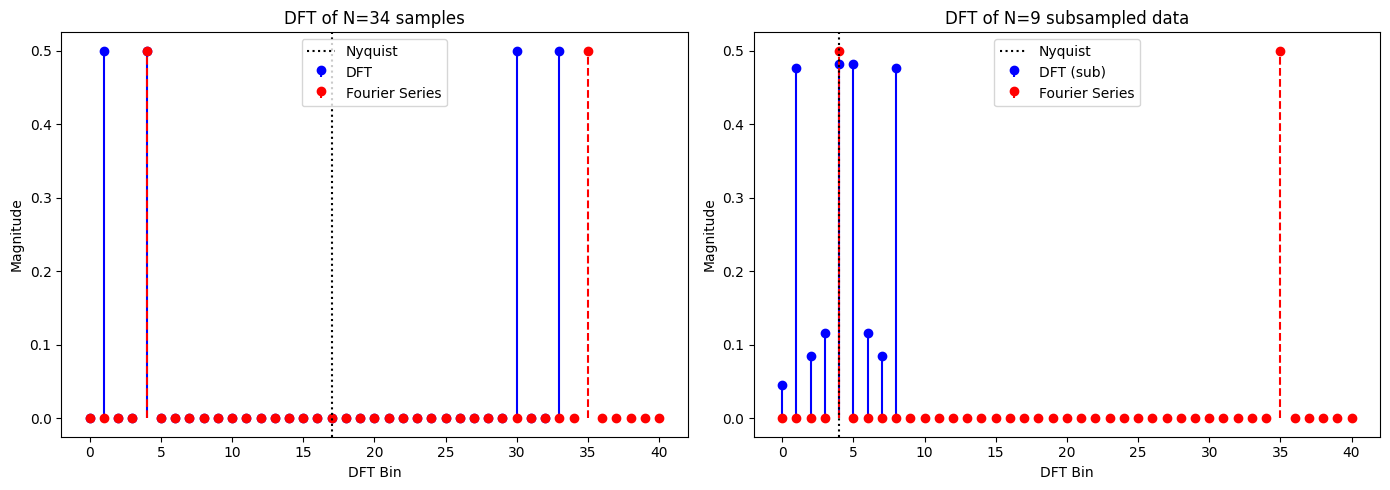

In [101]:
M = 33
N = M + 1  # Number of points
T = 1.0

# Function with modes as integer multiples of M
def f(t):
    return np.sin(2 * np.pi * 35 * t) + np.cos(2 * np.pi * 4 * t)

def fourier_series_coeffs(func, T, N_coeffs):
    coeffs = []
    for k in range(N_coeffs):
        integrand = lambda t: func(t) * np.exp(-1j * 2 * np.pi * k * t / T)
        c_k, _ = quad(lambda t: np.real(integrand(t)), 0, T)
        c_k_im, _ = quad(lambda t: np.imag(integrand(t)), 0, T)
        c_k = (c_k + 1j * c_k_im) / T
        coeffs.append(c_k)
    return np.array(coeffs)

N_ff = 41

t_samples = np.linspace(0, T, N, endpoint=False)
x_samples = f(t_samples)

dft_coeffs = np.fft.fft(x_samples) / N
dft_coeffs[np.isclose(np.abs(dft_coeffs), 0, atol=1e-10)] = 0

fs_coeffs = fourier_series_coeffs(f, T, N_ff)
fs_coeffs[np.isclose(np.abs(fs_coeffs), 0, atol=1e-10)] = 0

s = 4
N_sub = int(np.ceil(N / s))
t_sub = t_samples[::s]
x_sub = f(t_sub)

dft_sub = np.fft.fft(x_sub) / N_sub
dft_sub[np.isclose(np.abs(dft_sub), 0, atol=1e-10)] = 0

nyquist_bin = N // 2
nyquist_bin_sub = N_sub // 2

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.stem(np.arange(N), np.abs(dft_coeffs), linefmt='b-', markerfmt='bo', basefmt=' ')
plt.stem(np.arange(N_ff), np.abs(fs_coeffs), linefmt='r--', markerfmt='ro', basefmt=' ')
plt.axvline(nyquist_bin, color='k', linestyle=':', label='Nyquist')
plt.title(f'DFT of N={N} samples')
plt.xlabel('DFT Bin')
plt.ylabel('Magnitude')
plt.legend(["Nyquist", 'DFT', 'Fourier Series'])

plt.subplot(1, 2, 2)
plt.stem(np.arange(N_sub), np.abs(dft_sub), linefmt='b-', markerfmt='bo', basefmt=' ')
plt.stem(np.arange(N_ff), np.abs(fs_coeffs), linefmt='r--', markerfmt='ro', basefmt=' ')
plt.axvline(nyquist_bin_sub, color='k', linestyle=':', label='Nyquist')
plt.title(f'DFT of N={N_sub} subsampled data')
plt.xlabel('DFT Bin')
plt.ylabel('Magnitude')
plt.legend(['Nyquist','DFT (sub)', 'Fourier Series'])

plt.tight_layout()
plt.show()
